In [1]:
%%capture
# Local installation
!git clone https://github.com/speechbrain/speechbrain/
%cd /content/speechbrain/
!pip install -r requirements.txt
!pip install -e .
%%capture
# For pip installation
!pip install speechbrain

In [2]:
import speechbrain as sb
import os
import pandas as pd
import torchaudio
import numpy as np
import soundfile
from speechbrain.inference.speaker import EncoderClassifier
from tqdm import tqdm
import pickle

/content/speechbrain/speechbrain/utils/torch_audio_backend.py:60: UserWarning: torchaudio._backend.list_audio_backends has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  available_backends = torchaudio.list_audio_backends()
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _speechbrain_save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _speechbrain_load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _save
DEBUG:speechbrain.utils.checkpoints:Registered chec

In [ ]:
!wget http://lsa.tmit.bme.hu/files/age-samples.zip
!unzip HungarianEmotionalSentences.zip
dir = "/content/speechbrain/"
# read file list
files = os.listdir(dir)
print(files)

# read metadata
meta = pd.read_csv(dir + "/2021o6_meta_hc.csv",sep=";")
meta

['DE_0000_28_f.wav', 'DE_0001_36_m.wav', 'DE_0002_25_m.wav', 'DE_0003_43_m.wav', 'DE_0004_27_m.wav', 'DE_0005_37_f.wav', 'DE_0006_23_f.wav', 'DE_0007_21_f.wav', 'DE_0008_25_m.wav', 'DE_0009_45_f.wav', 'DE_0010_20_f.wav', 'DE_0011_32_f.wav', 'DE_0012_40_m.wav', 'DE_0013_18_f.wav', 'DE_0014_28_f.wav', 'DE_0015_34_f.wav', 'DE_0016_21_m.wav', 'DE_0017_32_f.wav', 'DE_0018_16_f.wav', 'DE_0019_21_m.wav', 'DE_001_M.wav', 'DE_0020_38_m.wav', 'DE_0021_50_f.wav', 'DE_0022_20_f.wav', 'DE_0023_15_f.wav', 'DE_0024_33_f.wav', 'DE_0025_18_m.wav', 'DE_0026_30_m.wav', 'DE_0027_31_m.wav', 'DE_0028_32_m.wav', 'DE_0029_35_f.wav', 'DE_002_M.wav', 'DE_0030_35_f.wav', 'DE_0031_39_f.wav', 'DE_0032_43_f.wav', 'DE_0033_23_f.wav', 'DE_0034_36_f.wav', 'DE_0035_47_f.wav', 'DE_0036_14_f.wav', 'DE_0037_25_m.wav', 'DE_0038_28_f.wav', 'DE_0039_43_f.wav', 'DE_003_M.wav', 'DE_0040_15_m.wav', 'DE_0041_17_f.wav', 'DE_0042_18_f.wav', 'DE_0043_31_f.wav', 'DE_0044_20_f.wav', 'DE_0045_19_f.wav', 'DE_0046_39_m.wav', 'DE_0047_16

,sample,sex,age
0,HC_031ffi,male,51
1,HC_032ffi,male,60
2,HC_033ffi,male,52
3,HC_034ffi,male,44
4,HC_035ffi,male,25
...,...,...,...
221,HE_H029_F_01,female,67
222,HE_H030_F_01,male,75
223,HE_H031_F_01,male,76
224,HE_H032_F_01,female,77


In [ ]:
# calculate embeddings
classifier = EncoderClassifier.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb", run_opts={"device":"cuda"})
signals = []
names = []
ages = []
sexes = []
embeddings = []
for _f in tqdm(files):
    meta_sel = meta[meta["sample"].str.lower() == _f.replace(".wav","").lower()]
    if len(meta_sel) > 0:
        ages.append(meta_sel.iloc[0]["age"])
        sexes.append(meta_sel.iloc[0]["sex"])
        names.append(_f)

        # calc emb
        signal, fs =torchaudio.load(dir + _f)
        embedding = classifier.encode_batch(signal)
        embeddings.append(np.array(embedding[0][0].cpu()))



  0%|          | 0/706 [00:00<?, ?it/s]c:\Users\david\.conda\envs\speechbrain_new\lib\site-packages\torchaudio\_backend\utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
100%|██████████| 706/706 [08:21<00:00,  1.41it/s]


In [ ]:
from sklearn import metrics
from sklearn.model_selection import LeaveOneOut
from sklearn import svm
from sklearn.manifold import TSNE
loo = LeaveOneOut()
X = np.array(embeddings)
y = np.array(sexes)
loo.get_n_splits(X)

orig = []
pred = []

for i, (train_index, test_index) in enumerate(loo.split(X)):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]

    clf = svm.SVC(kernel = 'linear', probability=(False))
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    orig.append(y_test[0])
    pred.append(y_pred)

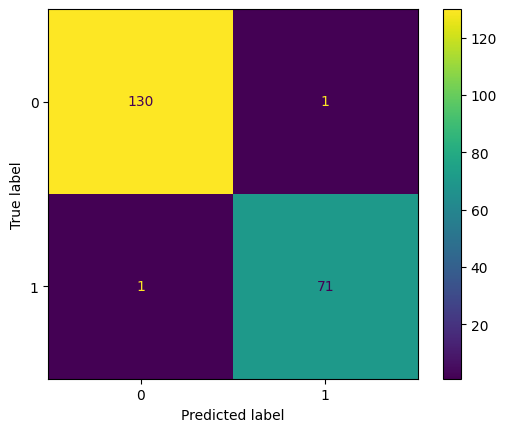

In [ ]:
import matplotlib.pyplot as plt
cm = metrics.confusion_matrix(orig, pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

13.473070116581331


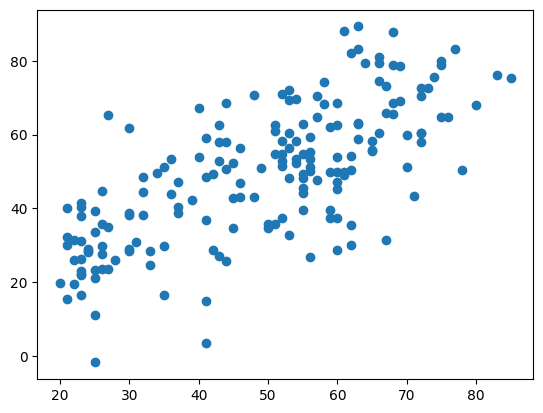

In [ ]:
from sklearn import metrics
from sklearn.model_selection import LeaveOneOut, KFold
from sklearn import svm
from sklearn.manifold import TSNE
loo = LeaveOneOut()
kf = KFold(n_splits=5)
ages = np.array(ages)
X = np.array(embeddings)
X = X[ages!="-"]
y = ages[ages!="-"].astype(np.float16)
y = np.array(y)
loo.get_n_splits(X)
kf.get_n_splits(X)

orig = []
pred = []

for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]

    clf = svm.SVR(kernel = 'linear')
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    orig.extend(y_test)
    pred.extend(y_pred)

from sklearn.metrics import root_mean_squared_error
plt.scatter(orig,pred)
print(root_mean_squared_error(orig,pred))

17.825912528726743


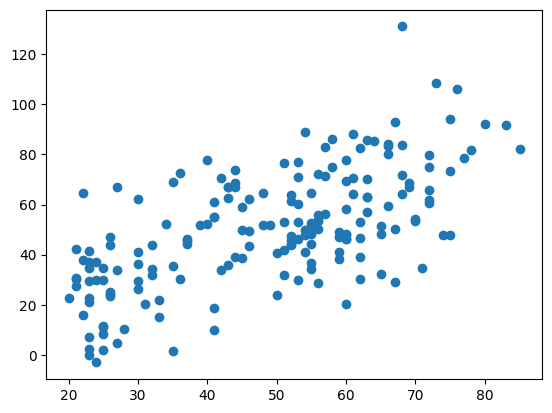